In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" ### Determine the GPU to be used. without commenting out this line of code, only nocuda = 9 can be selected later.
import numpy as np
import math
import matplotlib.pyplot as plt
import torch             
import torch.nn as nn    
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from early_stopping import EarlyStopping
import random 
import subprocess
import gc
import time

def get_gpu_memory(device_id):
    """
    Retrieve the memory usage of a specific GPU.

    Parameters:
    device_id: ID of the GPU device to query.

    Returns: A tuple (memory_used, memory_total) in MB, or (None, None) if an error occurs.
    """
    try:
        output = subprocess.check_output(["nvidia-smi", "--id={}".format(device_id), "--query-gpu=memory.used,memory.total", "--format=csv,nounits,noheader"])
        memory_used, memory_total = map(int, output.decode("utf-8").strip().split("\n")[0].split(","))
        return memory_used, memory_total
    except Exception as e:
        print(e)
        return None, None

def get_free_gpu():
    """
    Find the GPU with the most available memory and return its device ID.
    
    Returns:
    torch.device or None: The device with the most free memory if available, otherwise None.
    """
    device_ids = list(range(torch.cuda.device_count()))
    memory_usages = []
    for device_id in device_ids:
        memory_used, memory_total = get_gpu_memory(device_id)
        if memory_used is not None and memory_total is not None:
            memory_free = memory_total - memory_used
            memory_usages.append((device_id, memory_free))
        print(memory_total,memory_usages)
    if len(memory_usages) > 0:
        best_device_id = sorted(memory_usages, key=lambda x: x[1])[len(device_ids)-1][0]
        device = torch.device(f"cuda:{best_device_id}")
        return device
    else:
        return None


class Args:
    """
    A class to store tuning parameters for model training.
    
    Attributes:
    batch_size: batch size.
    lr: Learning rate for the optimizer.
    nepoch: Total number of epochs for training.
    patience: Number of epochs to wait for improvement before stopping early.
    wide: Width of the model, representing the number of units in each layer.
    depth: Depth of the model, representing the number of layers.
    n_train (int): Sample size.
    m_train (int): Sampling frequency.
    biaoji (str): A unique identifier to aovid confusion.
    """
    def __init__(self, batch_size=10, lr =0.001, nepoch = 300, patience = 10, wide = 100, depth = 5, n_train=1, m_train=1) -> None:
        self.batch_size = batch_size
        self.lr = lr
        self.nepoch = nepoch 
        self.patience = patience 
        self.wide = wide 
        self.depth = depth 
        self.biaoji = "wide" + str(wide) + "depth" + str(depth) + "n" + str(n_train) + "m" + str(m_train)
        self.n_train = n_train
        self.m_train = m_train


class EarlyStopping():
    """
    Early stopping utility to halt training when validation loss does not improve.
    
    Attributes:
    save_path: Path where model checkpoints are saved.
    patience: Number of epochs to wait for improvement before stopping.
    verbose: If True, prints validation loss improvements.
    delta: Minimum change in validation loss to qualify as an improvement.
    counter: Tracks epochs without improvement.
    best_score: Best score achieved on validation loss (initialized to None).
    early_stop: Flag to indicate if training should be stopped.
    val_loss_min: Tracks the minimum validation loss seen so far.
    """
    def __init__(self, save_path, args, verbose=False, delta=0):
        self.save_path = save_path 
        self.patience = args.patience 
        self.verbose = verbose 
        self.counter = 0 
        self.best_score = None 
        self.early_stop = False 
        self.val_loss_min = np.Inf 
        self.delta = delta 

    def __call__(self, model, train_loss, valid_loss, test_error, args, seed):

        score = -valid_loss 

        if self.best_score is None: 
            self.best_score = score 
            self.save_checkpoint(model, train_loss, valid_loss, test_error, args, seed) 
        elif score < self.best_score + self.delta: 
            self.counter += 1 
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}') 
            if self.counter >= self.patience: 
                self.early_stop = True 
        else:
            self.best_score = score
            self.save_checkpoint(model, train_loss, valid_loss, test_error, args, seed)
            self.counter = 0

    def save_checkpoint(self, model, train_loss, valid_loss, test_error, args, seed):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...') 
        torch.save(model, os.path.join(self.save_path, 'best' + str(seed) + args.biaoji +'network.pth') )
        torch.save(train_loss, os.path.join(self.save_path, 'best'+ str(seed) + args.biaoji +'train_loss.pth')) 
        torch.save(valid_loss, os.path.join(self.save_path, 'best'+ str(seed) + args.biaoji +'valid_loss.pth')) 
        torch.save(test_error, os.path.join(self.save_path, 'best'+ str(seed) + args.biaoji +'test_loss.pth')) 

        self.val_loss_min = valid_loss
    


class Dataset_repeatedmeasurement(Dataset): 
    """
    A custom dataset class for handling repeated measurement data.
    
    Attributes:
    x: Input data of features.
    y: Target labels corresponding to the input data.
    
    Methods:
    __len__: Returns the total number of samples in the dataset.
    __getitem__: Retrieves a single sample, returning a dictionary with 'x' and 'y' keys.
    """
    def __init__(self, x, y) -> None:  
        super().__init__()
        self.x = x 
        self.y = y 

    def __len__(self) -> int: 
        return len(self.x) 
    
    def __getitem__(self, index): 
        return {
            "x" : self.x[index], 
            "y" : self.y[index]
        }

class happynet(nn.Module):
    """
    A flexible neural network with a customizable depth.
    
    Parameters:
    n_feature: Dimension of input.
    n_hidden: Number of units in each hidden layer.
    n_output: Number of output units.
    n_layer: the number of layers (supports 3 to 10 layers). 
             (n_layer-1) hidden layers
    
    Methods:
    forward(x): Forward pass through the network.
    """
    def __init__(self, n_feature, n_hidden, n_output, n_layer): 
        super().__init__()
        if n_layer == 3: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_output), 
            )
        elif n_layer == 2: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_output), 
            )    
        elif n_layer == 4: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_output), 
            )
        elif n_layer == 5: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        elif n_layer == 6: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        elif n_layer == 7: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        elif n_layer == 8: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        elif n_layer == 9: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        elif n_layer == 10: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        else: 
            print("Error! the depth is not in 3-10")
    
    def forward(self, x):
        k = self.net(x)
        return k





def GPUstrain(x, y, x_valid, y_valid, x_test, y_test,args,seed,nocuda):  
    """
    Train a neural network on GPU or CPU based on the given configuration, using early stopping.
    
    Parameters:
    x: Training input data.
    y: Training target data.
    x_valid: Validation input data.
    y_valid: Validation target data.
    x_test: Test input data.
    y_test: Test target data.
    args: Arguments object containing hyperparameters.
    seed: Seed and identifier.
    nocuda (int): Flag to select device; options include specific GPU IDs, CPU, or auto-selection.
    
    Returns:
    tuple: (trained network, list of training losses, list of validation losses, list of test errors)
    """

    x_dim = x.shape[1]  
    if nocuda == 0:
        device = torch.device("cuda:0")
    if nocuda == 1:
        device = torch.device("cuda:1")
    if nocuda == 100:
        device = get_free_gpu()
    if nocuda == -1:
        device = torch.device("cpu")
    if nocuda == 9:
        device = torch.device("cuda")

    net = happynet(n_feature=x_dim, n_hidden=args.wide, n_output=1, n_layer=args.depth).to(device)
    nepoch = args.nepoch
    
    optimizer=torch.optim.Adam(net.parameters(), lr=args.lr, betas=(0.90, 0.999), eps=1e-8, weight_decay=0., amsgrad=False,) 
    loss_func=nn.MSELoss() 
    train_epochs_loss = [] 
    valid_epochs_loss = [] 
    test_epochs_error = [] 

    x = x.reshape(-1,x_dim)
    y = y.reshape(-1)

    train_dataset = Dataset_repeatedmeasurement(x,y)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)

    x=torch.from_numpy(x).float() 
    y=torch.from_numpy(y).float() 
    x_valid=torch.from_numpy(x_valid).float().to(device) 
    y_valid=torch.from_numpy(y_valid).float().to(device) 

    x_test = torch.from_numpy(x_test).float().view(-1,1,x_dim).to(device)
    y_test = torch.from_numpy(y_test).float().view(-1).to(device) 


    save_path = "../resultsv" 
    early_stopping = EarlyStopping(save_path,args=args)

    for epoch in range(nepoch): 
        net.train()
        train_epoch_loss = []


        # =========================train=========================
        for idx, traindata in enumerate(train_dataloader):

            x_train = traindata["x"]
            y_train = traindata["y"]

            x_train=torch.Tensor(x_train).float().view(-1,1,x_dim).to(device) 
            y_train=torch.Tensor(y_train).float().to(device) 
            outputs=net(x_train) 
            loss=loss_func(outputs.view(-1),y_train.view(-1).float())
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 
            
            
            train_epoch_loss.append(loss.item())

        del outputs, loss

        train_epochs_loss.append(np.average(train_epoch_loss))
        # =========================valid=========================
        with torch.no_grad():
            net.eval() 
            valid_predict=net(x_valid.view(-1,1,x_dim))
            valid_y_pre=valid_predict.view(-1).detach()
            valid_y_pre=torch.Tensor(valid_y_pre).float()
            loss_valid=loss_func(valid_y_pre, y_valid.view(-1).float())
            valid_epochs_loss.append(loss_valid.item())

            test_predict=net(x_test)
            test_y_pre=test_predict.view(-1).detach()
            test_y_pre=torch.Tensor(test_y_pre).float()
            error_test=loss_func(test_y_pre, y_test)
            test_epochs_error.append(error_test.item())

        print("epoch = {}, training loss = {}, validation loss = {}, test error = {}".format(epoch, np.average(train_epoch_loss), loss_valid, error_test))

        if epoch > 10 or args.n_train*args.m_train > 200:
            early_stopping(net, np.average(train_epoch_loss), loss_valid, error_test,args,seed)
            if early_stopping.early_stop: 
                print("Early stopping")
                break #跳出迭代，结束训练


        del valid_predict, valid_y_pre, loss_valid
        del test_predict, test_y_pre, error_test
    gc.collect()

    return net, train_epochs_loss, valid_epochs_loss, test_epochs_error


def kernel(x,y):
    """
    Compute the Laplacian kernel between two points x and y.
    $$ k(x,y) = \exp(-\|x-y\|) $$
    
    Returns: k(x,y).
    """
    d = np.sqrt(np.sum((x-y)**2))
    return np.exp(-d)
bankernel0 = 1 # k(x,x)=1



def RKHS_train(x, y, x_valid, y_valid, x_test, y_test, lambdac_set = np.geomspace(1e-8, 1, 20)):
    """
    Train a model using Reproducing Kernel Hilbert Space (RKHS) methods to fit data, 
    selecting the optimal regularization parameter through validation.
    
    Parameters:
    n_train: sample size.
    m_train: sampling frequency.
    seed: Seed for data loading, used to identify the data file.
    datapath: Path to the data file.
    lambdac_set: Array of regularization parameters.
    
    Returns:
    tuple: A tuple containing:
        - valid_loss: Array with validation losses and corresponding lambda values.
        - test_error_result: Mean squared error on the test data using the optimal lambda.
    """

    T1 = time.time()
    valid_loss = np.ndarray((lambdac_set.shape[0],2))
    Phi = np.ndarray((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if i<j:
                Phi[i,j] = kernel(x[i,],x[j,]) 
            if i==j:
                Phi[i,j] = bankernel0/2
            if i>j:
                Phi[i,j] = 0
    Phi = Phi + Phi.T

    Phi_valid = np.ndarray((x.shape[0],x_valid.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x_valid.shape[0]):
            Phi_valid[i,j] = kernel(x[i,],x_valid[j,])

    Phi_test = np.ndarray((x.shape[0],x_test.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x_test.shape[0]):
            Phi_test[i,j] = kernel(x[i,],x_test[j,])

    valid_loss = np.ndarray((lambdac_set.shape[0],2))

    for ijj in range(lambdac_set.shape[0]):
        lambdac = lambdac_set[ijj]

        coef = np.linalg.solve(Phi+x.shape[0]*lambdac*np.diag(np.ones(x.shape[0])), y)
        valid_loss[ijj,0] = np.mean((Phi_valid.T@coef - y_valid)**2)
        valid_loss[ijj,1] = lambdac

    test_error = [] 
    indopth = valid_loss[:,0].argmin()
    lambdaopt = np.array(valid_loss)[indopth,1]
    coef = np.linalg.solve(Phi+x.shape[0]*lambdaopt*np.diag(np.ones(x.shape[0])), y)
    test_error_result = np.mean(((Phi_test.T@coef) - y_test)**2)

    T2 =time.time()
    print('程序运行时间:%s毫秒' % ((T2 - T1)*1000))
    return test_error_result



def local_linear_estimator(x1, y1, x0, bandwidth): 
    """
    Perform a local linear regression to estimate the value at a new data point x0.
    
    Parameters:
    x1: Training data x.
    y1: Training data y.
    x0: New data point for prediction.
    bandwidth: Bandwidth parameter controlling the weighting decay with distance.
    
    Returns:The predicted value at x0 based on local linear regression.
    """
    x_dim = x1.shape[1] 
    dx_aug = np.hstack((np.ones((x1.shape[0], 1)), x1-x0)) 
    distances = np.linalg.norm(x1-x0, axis=1) 
    dh = distances**2/(bandwidth * x_dim)
    weights = np.where(dh<1,1-dh,0)
    W = np.diag(weights)
    prediction = np.linalg.solve(dx_aug.T @ W @ dx_aug + 0.00001*np.diag(np.ones(x_dim+1)) , dx_aug.T @ (weights*y1))[0]
    return prediction 
   

def local_linear_train(x, y, x_valid, y_valid, x_test, y_test, bandwidth_set=np.geomspace(10**(-8), 1, 20)):
    """
    Train a local linear estimator using a training dataset, select the tuning parameter on validation data and evaluate on test data.
    
    Parameters:
    n_train: Number of training samples.
    m_train: Number of observations per training sample.
    seed: Seed for data loading, used to identify the data file.
    datapath: Path to the data file.
    bandwidth_set: Array of bandwidth values to test for the local linear estimator.
    
    Returns:
    tuple: A tuple containing:
        - valid_loss: Array with validation losses and corresponding bandwidths.
        - test_error_result: Mean squared error on the test data using the optimal bandwidth.
    """
    
    x_dim = x.shape[1]
    x1 = x.reshape(-1,x_dim)
    y1 = y.reshape(-1)
    x_valid = x_valid.reshape(-1,x_dim)
    y_valid = y_valid.reshape(-1)

    print("data is realy")

    T1 = time.time()
    valid_loss = np.ndarray((bandwidth_set.shape[0],2))
    for ijj in range(bandwidth_set.shape[0]):
        bandwidth = list(bandwidth_set)[ijj]
        for i in range(x_valid.shape[0]):
            valid_loss_s = []
            x0 = x_valid[i,]
            res = local_linear_estimator(x1, y1, x0, bandwidth)
            valid_loss_s.append((res-y_valid[i])**2)
        valid_loss[ijj,0]=np.mean(valid_loss_s)
        valid_loss[ijj,1]=bandwidth

    test_error = [] 
    indopth = valid_loss[:,0].argmin()
    hopt = np.array(valid_loss)[indopth,1]
    for i in range(x_test.shape[0]):
        if(i%1000 == 0):
            print("test data:"+str(i))
        x0 = x_test[i,]
        res = local_linear_estimator(x1, y1, x0, hopt)
        test_error.append((res-y_test[i])**2)
    test_error_result = np.mean(test_error)

    T2 =time.time()
    print('程序运行时间:%s毫秒' % ((T2 - T1)*1000))
    return test_error_result

In [ ]:
torch.manual_seed(123) 
np.random.seed(123) 
random.seed(123) 
torch.cuda.manual_seed_all(123) 

# Load data
data = pd.read_csv('./data/data_eps1.csv')
data['time'] = pd.to_datetime(data['time'])

# Define variables for features and target
var_x = ['so2', 'no2', 'o3', 'co', 'WSPM', 'humi', 'dewp', 'pres']
var_y = ['pm25']
var_all = ['id_eps', 'hour_eps'] + var_y + var_x

# Filter data based on 'hour_eps' and remove rows with missing values
data_used = data[data['hour_eps'] <= 48][var_all].copy().dropna(axis=0, how='any')

# Normalize variables
data_used['so2'] = ((data_used['so2']-data_used['so2'].min())/(data_used['so2'].max()-data_used['so2'].min()) - 0.5)*2
data_used['no2'] = ((data_used['no2']-data_used['no2'].min())/(data_used['no2'].max()-data_used['no2'].min()) - 0.5)*2
data_used['o3'] = ((data_used['o3']-data_used['o3'].min())/(data_used['o3'].max()-data_used['o3'].min())- 0.5)*2
data_used['co'] = ((data_used['co']-data_used['co'].min())/(data_used['co'].max()-data_used['co'].min())- 0.5)*2
data_used['WSPM'] = ((data_used['WSPM']-data_used['WSPM'].min())/(data_used['WSPM'].max()-data_used['WSPM'].min())- 0.5)*2
data_used['humi'] = ((data_used['humi']-data_used['humi'].min())/(data_used['humi'].max()-data_used['humi'].min())- 0.5)*2
data_used['dewp'] = ((data_used['dewp']-data_used['dewp'].min())/(data_used['dewp'].max()-data_used['dewp'].min())- 0.5)*2
data_used['pres'] = ((data_used['pres']-data_used['pres'].min())/(data_used['pres'].max()-data_used['pres'].min())- 0.5)*2
data_used['pm25'] = np.log(data_used['pm25']) # Log-transform the target variable

# Split indices into training, validation, and test sets
n_total = 94
randind = list(range(1,n_total+1))
random.shuffle(randind)
train_ind = [randind[i] for i in range(0, math.ceil(n_total * 0.64 ))]
test_ind = [randind[i] for i in range(math.ceil(n_total * 0.64 ), math.ceil(n_total * 0.84))]
valid_ind = [randind[i] for i in range(math.ceil(n_total * 0.84), n_total)]
# Create final datasets for model training
x_train = np.array(data_used[data_used['id_eps'].isin(train_ind)][var_x].copy())
y_train = np.array(data_used[data_used['id_eps'].isin(train_ind)][var_y].copy())
x_valid = np.array(data_used[data_used['id_eps'].isin(valid_ind)][var_x].copy())
y_valid = np.array(data_used[data_used['id_eps'].isin(valid_ind)][var_y].copy())
x_test = np.array(data_used[data_used['id_eps'].isin(test_ind)][var_x].copy())
y_test = np.array(data_used[data_used['id_eps'].isin(test_ind)][var_y].copy())

## DNN estimation

In [ ]:
batch_size= 256
lr = 0.001
n_train = 61
m_train= 48

torch.manual_seed(123) 
np.random.seed(123) 
random.seed(123) 
torch.cuda.manual_seed_all(123) 
seed2 = 123

x = x_train
y = y_train
nocuda = 9
args = Args(lr=lr, wide=50, depth = 2, batch_size= batch_size, n_train=n_train, m_train=m_train)
GPUstrain(x=x,y=y,x_valid = x_valid,y_valid=y_valid,x_test=x_test, y_test=y_test, args=args,seed = seed2, nocuda = nocuda)

a = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'valid_loss.pth')
b = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'test_loss.pth')
net0 = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'network.pth')
a = np.expand_dims(a.cpu(), 0)
b = np.expand_dims(b.cpu(), 0)
c0 = np.r_[a,b,0]

args = Args(lr=lr, wide=100, depth = 3, batch_size= batch_size, n_train=n_train, m_train=m_train)
GPUstrain(x=x,y=y,x_valid = x_valid,y_valid=y_valid,x_test=x_test, y_test=y_test, args=args,seed = seed2, nocuda = nocuda)
a = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'valid_loss.pth')
b = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'test_loss.pth')
net1 = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'network.pth')
a = np.expand_dims(a.cpu(), 0)
b = np.expand_dims(b.cpu(), 0)
c1 = np.r_[a,b,1]


args = Args(lr=lr, wide=200, depth = 4, batch_size= batch_size, n_train=n_train, m_train=m_train)
GPUstrain(x=x,y=y,x_valid = x_valid,y_valid=y_valid,x_test=x_test, y_test=y_test, args=args,seed = seed2, nocuda = nocuda)
a = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'valid_loss.pth')
b = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'test_loss.pth')
net2 = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'network.pth')
a = np.expand_dims(a.cpu(), 0)
b = np.expand_dims(b.cpu(), 0)
c2 = np.r_[a,b,2]

args = Args(lr=lr, wide=400, depth = 5, batch_size= batch_size, n_train=n_train, m_train=m_train)
GPUstrain(x=x,y=y,x_valid = x_valid,y_valid=y_valid,x_test=x_test, y_test=y_test, args=args,seed = seed2, nocuda = nocuda)
a = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'valid_loss.pth')
b = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'test_loss.pth')
net3 = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'network.pth')
a = np.expand_dims(a.cpu(), 0)
b = np.expand_dims(b.cpu(), 0)
c3 = np.r_[a,b,3]

args = Args(lr=lr, wide=600, depth = 6, batch_size= batch_size, n_train=n_train, m_train=m_train)
GPUstrain(x=x,y=y,x_valid = x_valid,y_valid=y_valid,x_test=x_test, y_test=y_test, args=args,seed = seed2, nocuda = nocuda)
a = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'valid_loss.pth')
b = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'test_loss.pth')
net4 = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'network.pth')
a = np.expand_dims(a.cpu(), 0)
b = np.expand_dims(b.cpu(), 0)
c4 = np.r_[a,b,4]

args = Args(lr=lr, wide=800, depth = 6, batch_size= batch_size, n_train=n_train, m_train=m_train)
GPUstrain(x=x,y=y,x_valid = x_valid,y_valid=y_valid,x_test=x_test, y_test=y_test, args=args,seed = seed2, nocuda = nocuda)
a = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'valid_loss.pth')
b = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'test_loss.pth')
net5 = torch.load('../resultsv/best'+ str(seed2) + args.biaoji +'network.pth')
a = np.expand_dims(a.cpu(), 0)
b = np.expand_dims(b.cpu(), 0)
c5 = np.r_[a,b,5]

p = np.r_[np.expand_dims(c0, 0),np.expand_dims(c1, 0),np.expand_dims(c2, 0),np.expand_dims(c3, 0),np.expand_dims(c4, 0),np.expand_dims(c5, 0)]#
ind = np.argmin(p[:,0])
torch.save(eval("net"+str(ind)) , './resultnet.pth')

epoch = 0, training loss = 18.359848022460938, validation loss = 17.703144073486328, test error = 18.055570602416992
epoch = 1, training loss = 16.622060775756836, validation loss = 16.206682205200195, test error = 16.468835830688477
epoch = 2, training loss = 15.12322694605047, validation loss = 14.698648452758789, test error = 14.863580703735352
epoch = 3, training loss = 13.531660426746715, validation loss = 13.122602462768555, test error = 13.180728912353516
epoch = 4, training loss = 11.80270966616544, validation loss = 11.461177825927734, test error = 11.404657363891602
epoch = 5, training loss = 10.080492799932307, validation loss = 9.735244750976562, test error = 9.564884185791016
epoch = 6, training loss = 8.282868602059104, validation loss = 8.001703262329102, test error = 7.730406284332275
epoch = 7, training loss = 6.538442741740834, validation loss = 6.349712371826172, test error = 5.996413230895996
epoch = 8, training loss = 4.926220178604126, validation loss = 4.87982368

In [7]:
p[np.argmin(p[:,0]),1]

0.11422593

In [7]:
np.var(y_test)

0.5098630470256653

## RKHS estimation

In [11]:
resRKHS = RKHS_train(x_train, y_train, x_valid, y_valid, x_test, y_test, lambdac_set = np.geomspace(1e-8, 1, 20))
resRKHS

程序运行时间:195055.7930469513毫秒


0.15209557536572313

## Local linear

In [12]:
locallinear = local_linear_train(x_train, y_train, x_valid, y_valid, x_test, y_test,bandwidth_set=np.geomspace(5*10**(-2), 1, 8))
locallinear

data is realy
test data:0
程序运行时间:147765.67459106445毫秒


0.1691259366459222

## Linear regression

In [20]:
np.mean((y_test - x_test @ np.linalg.solve(x_train.T @ x_train,x_train.T @y_train))**2)

0.444908800330544

## Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


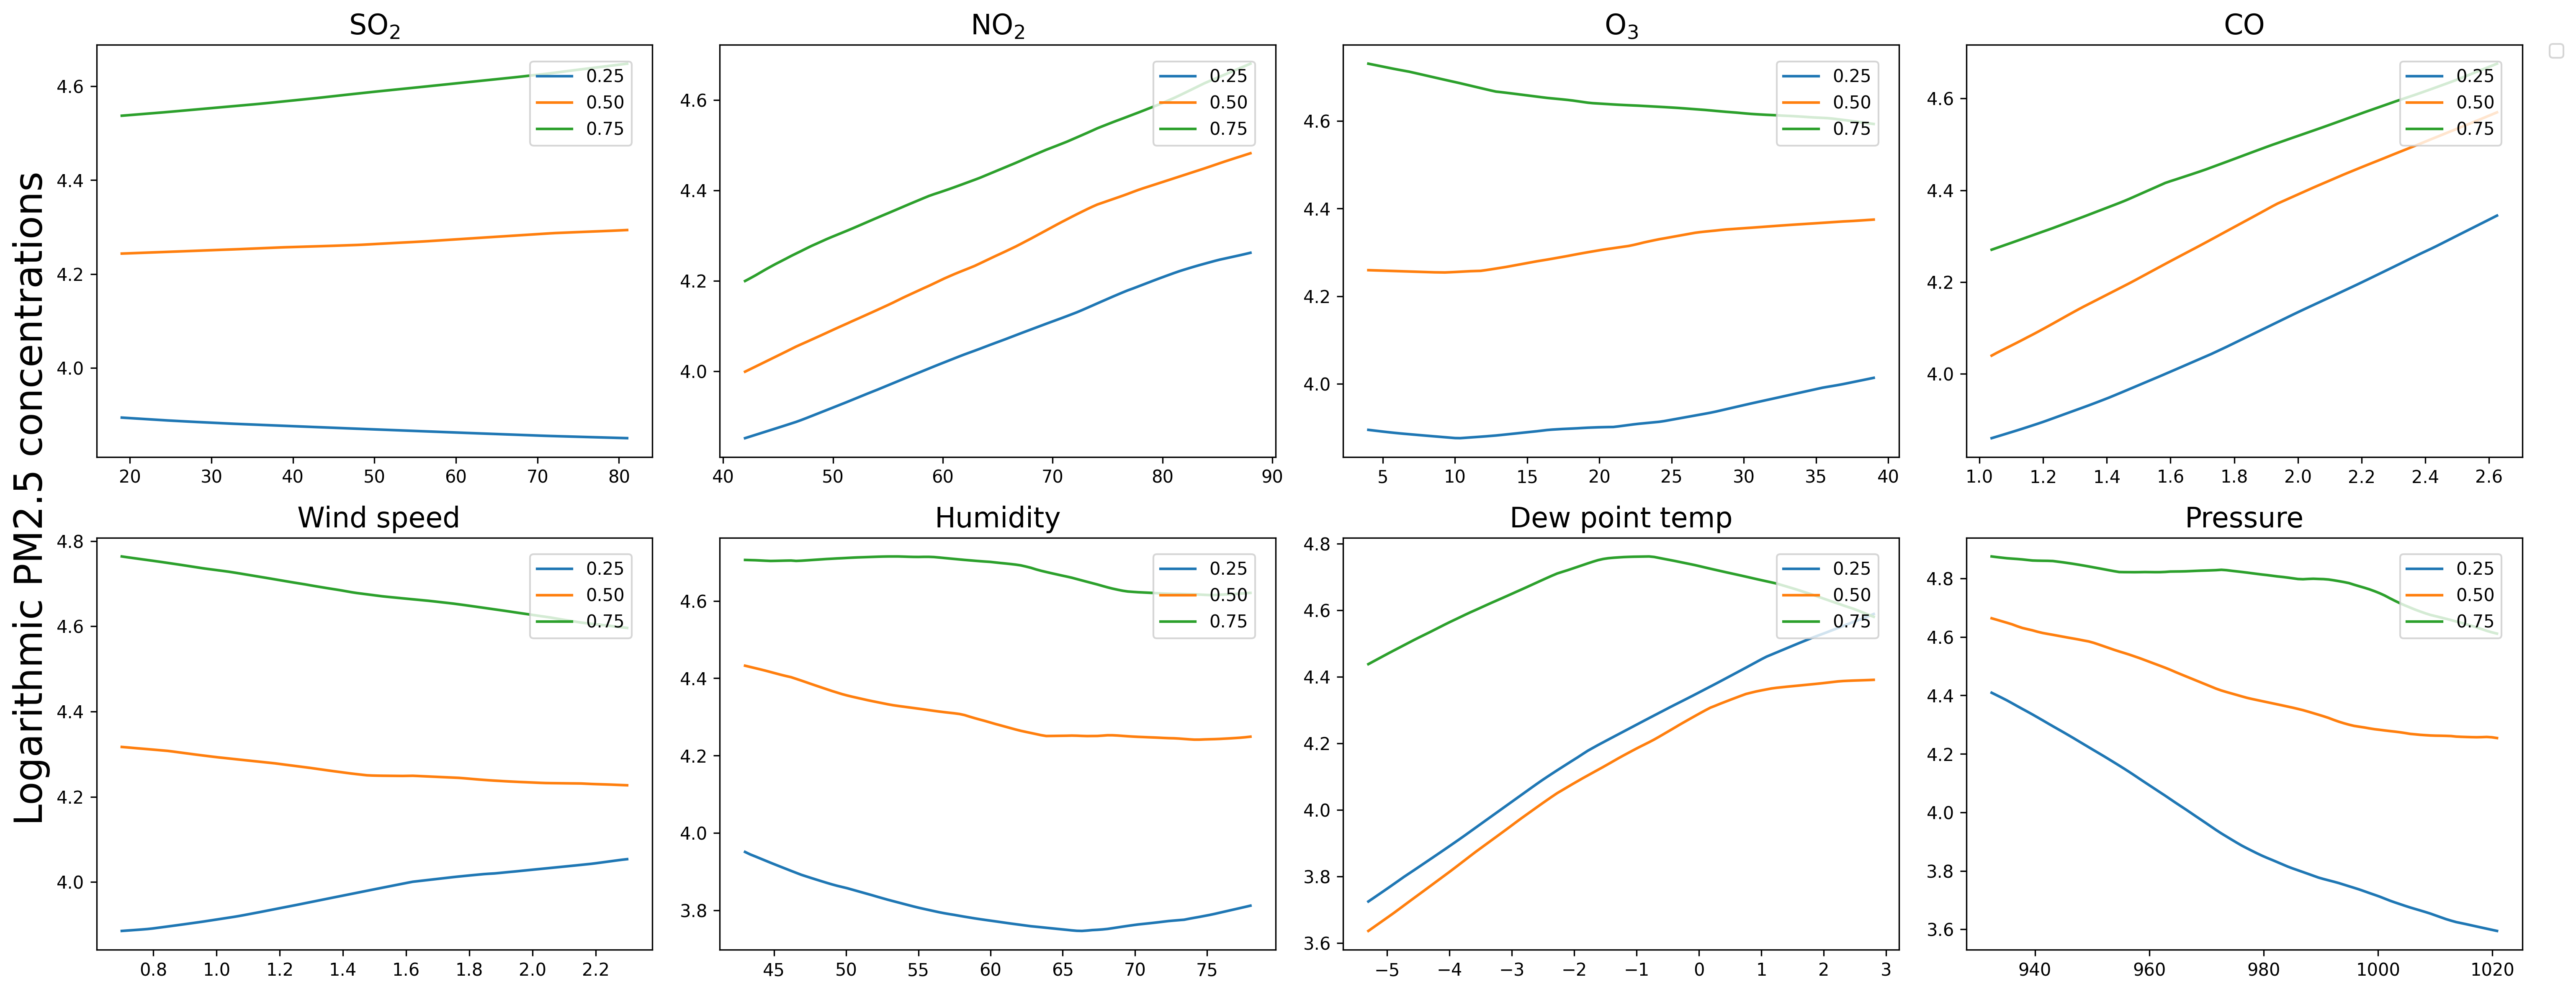

In [ ]:
def subplotv(ax,i):
    """
    Plot three percentiles (25th, 50th, and 75th) of the specified variable in var_x 
    on the provided matplotlib axis `ax`.

    Parameters:
    ax (matplotlib.axes.Axes): The axis to plot on.
    i (int): Index of the variable in var_x to vary in the plot.
    """
    net = torch.load('./resultnet.pth').to("cuda:0")
    name = var_x[i]
    p = 25
    zb = np.percentile(x_train, p, axis=0)
    zb[i] = -1
    N = 100
    low = np.percentile(x_train, 20, axis=0)
    up = np.percentile(x_train, 80, axis=0)
    ind = np.where(np.array(zb) == -1)
    x_plot_r = (np.linspace(low[ind],up[ind],N) + 1) * (data[name].max() - data[name].min())/2 + data[name].min()
    x_plot = np.tile(zb, N).reshape(-1,1,8)
    x_plot = torch.from_numpy(x_plot).float().view(-1,1,8).to("cuda:0")
    x_plot[:,:,ind] = torch.linspace(low[ind][0],up[ind][0],N).view(-1,1,1,1).to("cuda:0")
    y_plot = net(x_plot)
    ax.plot(x_plot_r, y_plot.cpu().detach().numpy().reshape(-1), label='0.25')


    p = 50
    zb = np.percentile(x_train, p, axis=0)
    zb[i] = -1
    N = 100
    low = np.percentile(x_train, 20, axis=0)
    up = np.percentile(x_train, 80, axis=0)
    x_plot = np.tile(zb, N).reshape(-1,1,8)
    ind = np.where(np.array(zb) == -1)
    x_plot = torch.from_numpy(x_plot).float().view(-1,1,8).to("cuda:0")
    x_plot[:,:,ind] = torch.linspace(low[ind][0],up[ind][0],N).view(-1,1,1,1).to("cuda:0")
    y_plot = net(x_plot)
    ax.plot(x_plot_r, y_plot.cpu().detach().numpy().reshape(-1), label='0.50')


    p = 75
    zb = np.percentile(x_train, p, axis=0)
    zb[i] = -1
    N = 100
    low = np.percentile(x_train, 20, axis=0)
    up = np.percentile(x_train, 80, axis=0)
    x_plot = np.tile(zb, N).reshape(-1,1,8)
    ind = np.where(np.array(zb) == -1)
    x_plot = torch.from_numpy(x_plot).float().view(-1,1,8).to("cuda:0")
    x_plot[:,:,ind] = torch.linspace(low[ind][0],up[ind][0],N).view(-1,1,1,1).to("cuda:0")
    y_plot = net(x_plot)
    ax.plot(x_plot_r, y_plot.cpu().detach().numpy().reshape(-1),label='0.75')
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.legend(loc=2, bbox_to_anchor=(0.78,0.96), borderaxespad = 0.)
    ax.set_title(title_r[i],size = 16)
    


title_r = ['SO$_2$', 'NO$_2$', 'O$_3$', 'CO', ' Wind speed', 'Humidity', 'Dew point temp', 'Pressure']
fig, ((ax1, ax2, ax3, ax4), (ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols=4, dpi=300,figsize=(20,8))
fig.text(s='Logarithmic PM2.5 concentrations',rotation=90,x = -0.01, y = 0.18,fontsize = 22,) 
fig.legend(loc=2, bbox_to_anchor=(1,0.95), borderaxespad = 0.)
subplotv(ax1,0)
subplotv(ax2,1)
subplotv(ax3,2)
subplotv(ax4,3)
subplotv(ax5,4)
subplotv(ax6,5)
subplotv(ax7,6)
subplotv(ax8,7)

plt.tight_layout()